In [1]:
import sys
from pandas import *
import numpy as np
import matplotlib
from matplotlib import pyplot
import random
from scipy.stats import norm
import scipy.stats as scs
import os
import pybedtools
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time

In [2]:
def read_JASPAR_transfac_pfms(infile):
    pfms_file = open(infile,'r')
    pfms_info = {}
    seq_len = 0
    for line in pfms_file:
        line = line.split('\n')[0]
        if(len(line.split(' ')) > 1):
            line = line.split(' ')
            if(line[0] == 'DE'):
                pfms_info['Matrix_ID'] = line[1]
                pfms_info['Matrix_Name'] = line[2]
                seq_len = 0
            elif(line[0] == 'CC'):
                temp = line[1].split(':')
                pfms_info[temp[0]] = temp[1]
                if(seq_len > 0):
                    pfms_info['TF_len'] = seq_len
        elif(len(line.split('\t')) > 1):
            line = line.split('\t')
            if(line[0] == 'PO'):
                curr_matorder = line[1:]
            else:
                curr_vals = {}
                for n,v in enumerate(line[1:]):
                    curr_vals[curr_matorder[n]] = float(v)+1
                pfms_info[int(line[0])] = curr_vals
                seq_len = int(line[0])
        else:
            pass
#             print(line)
    pfms_file.close()
    return pfms_info

In [3]:
def get_matrix_byTFName(tfname,info_dicts,seq): #old
    seq = seq.upper()
    matrix_dict_touse = None
    for i in info_dicts:
        if(i['Matrix_Name'] == tfname):
            matrix_dict_touse = i
            break
    if(matrix_dict_touse == None):
        print('Could not find a PWM for Transcription Factor {0}'.format(tfname))
        return None
    seq_val = 0
    for n,b in enumerate(seq):
        try:
            seq_val += float(matrix_dict_touse[n+1][b])
        except:
            if(b not in 'ACTG'):
                print('Sequence contains a letter, {0}, that is not A/C/G/T at position {1}'.format(b,n))
            else:
                print('Sequence of length {0} is too long'.format(len(seq)))
            return None
    return seq_val

In [4]:
def get_matrix_byTF(tfname,info_dicts):
    matrix_dict_touse = None
    for i in info_dicts:
        if(i['Matrix_Name'] == tfname):
            matrix_dict_touse = i
            break
    if(matrix_dict_touse == None):
        print('Could not find a PWM for Transcription Factor {0}'.format(tfname))
        return None
    return matrix_dict_touse

def get_lnPWM_from_matrixdict(matrix_dict):
    lnPWM_dict = {}
    for en in range(1,matrix_dict['TF_len']+1):
        temp_matrix = {}
        for b in 'ACTG':
            f = float(matrix_dict[en][b])
            if(f == 0.0):
                temp_matrix[b] = np.log(1)
            else:
                temp_matrix[b] = np.log(f)
        lnPWM_dict[en] = temp_matrix
    return lnPWM_dict

In [5]:
def get_fraclnPWM_from_matrixdict(matrix_dict):
    lnPWM_dict = {}
    for en in range(1,matrix_dict['TF_len']+1):
        temp_matrix = {}
        curr_totcount = sum([float(x) for x in matrix_dict[en].values()])
        for b in 'ACTG':
            f = float(matrix_dict[en][b])/curr_totcount
            if(f == 0.0):
                temp_matrix[b] = np.log(1)
            else:
                temp_matrix[b] = np.log(f)
        lnPWM_dict[en] = temp_matrix
    return lnPWM_dict

def get_fracPWM_from_matrixdict(matrix_dict):
    PWM_dict = {}
    for en in range(1,matrix_dict['TF_len']+1):
        temp_matrix = {}
        curr_totcount = sum([float(x) for x in matrix_dict[en].values()])
        for b in 'ACTG':
            if(f == 0.0):
                temp_matrix[b] = 1/curr_totcount
            else:
                temp_matrix[b] = float(matrix_dict[en][b])/curr_totcount
        PWM_dict[en] = temp_matrix
    return PWM_dict

In [6]:

def get_frac_matrix_scores(tfname,pwm,ref_al,alt_al,position,reference_seq):
    ref_al = ref_al.upper()
    alt_al = alt_al.upper()
    reference_seq = reference_seq.upper()
    ref_seqval_list,alt_seqval_list = [],[]
    for n,b in enumerate(reference_seq):
        try:
            if(n == position):
                ref_seqval_list.append(float(pwm[n+1][ref_al]))
                alt_seqval_list.append(float(pwm[n+1][alt_al]))
            else:
                ref_seqval_list.append(float(pwm[n+1][b]))
                alt_seqval_list.append(float(pwm[n+1][b]))
        except:
            if(b not in 'ACTG'):
                print('Sequence contains a letter, {0}, that is not A/C/G/T at position {1}'.format(b,n))
                return None
            else:
                continue

    return ref_seqval_list,alt_seqval_list


In [7]:
def get_lnmatrix_scores(tfname,matrix_dict,ref_al,alt_al,position,reference_seq):
    ref_al = ref_al.upper()
    alt_al = alt_al.upper()
    reference_seq = reference_seq.upper()
    ref_seqval,alt_seqval = 0,0
    seqpos_counts = []
    seqpos_counts_bybase = {'A':[],'C':[],'G':[],'T':[],}
    for n,b in enumerate(reference_seq):
        try:
            if(n == position):
                ref_seqval += float(matrix_dict[n+1][ref_al])
                alt_seqval += float(matrix_dict[n+1][alt_al])
            else:
                ref_seqval += float(matrix_dict[n+1][b])
                alt_seqval += float(matrix_dict[n+1][b])
            curr_vals = [float(x) for x in matrix_dict[n+1].values()]
            seqpos_counts.append(sum(curr_vals))
            seqpos_counts_bybase['A'].append(matrix_dict[n+1]['A'])
            seqpos_counts_bybase['C'].append(matrix_dict[n+1]['C'])
            seqpos_counts_bybase['G'].append(matrix_dict[n+1]['G'])
            seqpos_counts_bybase['T'].append(matrix_dict[n+1]['T'])
        except:
            if(b not in 'ACTG'):
                print('Sequence contains a letter, {0}, that is not A/C/G/T at position {1}'.format(b,n))
                return None
            else:
                continue
        
#     total_count_fraction = seqpos_counts/len(seqpos_counts)
    refseq_fraction = ref_seqval/sum(seqpos_counts)
    altseq_fraction = alt_seqval/sum(seqpos_counts)
    return ref_seqval,alt_seqval,seqpos_counts_bybase

In [8]:
def get_numbp_forseq(seq):
    bpcounts = {'A':0,'C':0,'G':0,'T':0}
    for b in seq:
        try:
            bpcounts[b] += 1
        except:
            if(b not in 'ACTG'):
                print('Sequence contains a letter, {0}, that is not A/C/G/T!'.format(b))
    bpc_list = []
    for o in 'ACGT':
        bpc_list.append(bpcounts[o])
    return bpc_list
            
def compute_Y(seq,bg_props):
#     seq_bpcounts = get_numbp_forseq(seq)
    bpcounts = {'A':0,'C':0,'G':0,'T':0}
    for b in seq:
        try:
            bpcounts[b] += 1
        except:
            if(b not in 'ACTG'):
                print('Sequence contains a letter, {0}, that is not A/C/G/T!'.format(b))
    bpc_list = []
    for o in 'ACGT':
        bpc_list.append(bpcounts[o])
    Y = np.dot(np.log(bg_props),bpc_list)
    return Y

def make_seq(fullseq,position,allele):
    new_seq = ''
    for n,b in enumerate(fullseq):
        try:
            if(n==position):
                new_seq = ''.join([new_seq,allele])
            else:
                new_seq = ''.join([new_seq,b])
        except:
            if(b not in 'ACTG'):
                print('Sequence contains a letter, {0}, that is not A/C/G/T at position {1}'.format(b,n))
                return None
            else:
                print(b)
                continue
    return new_seq.upper()



In [9]:
def get_matrix_counts(pwm):
    pos_counts = []
    for en in pwm:
        temp = [float(x) for x in en.values()]
        pos_counts.append(sum(temp))
    return pos_counts
def get_complseq(seq):
    new_seq = []
    for b in seq:
        if(b == 'A'):
            new_seq.append('T')
        elif(b == 'T'):
            new_seq.append('A')
        elif(b == 'G'):
            new_seq.append('C')
        elif(b == 'C'):
            new_seq.append('G')
        else:
            print('Base pair not A/C/T/G! {0}'.format(b))
    return ''.join(new_seq)
            

In [10]:
def get_random_bgseqs(slen,reps,fastaloc,chrmsizes):
    # x = pybedtools.BedTool()
    chrms_touse = list(chrmsizes['chrom'])
    bgseq_list = []
    nrep = 0
    while(len(bgseq_list) < int(reps)):
#     for n in range(int(reps)):
        is_valid_seq = True
        curr_chrm = 8
        curr_start = random.randint(1,chrmsizes.loc[chrmsizes['chrom'] == 'chr{0}'.format(curr_chrm)]['size'].values[0])
        curr_end = curr_start + slen
        chrmfile = '{0}/chr{1}.fa'.format(fastaloc,curr_chrm)
        curr_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(curr_chrm,curr_start,curr_end),chrmfile)
        for b in curr_seq:
            if(b not in 'ACTG'):
                is_valid_seq = False
                continue
        if(is_valid_seq):
            bgseq_list.append({'chrm':curr_chrm,'start':curr_start,'end':curr_end,'seq':curr_seq.upper()})
    return bgseq_list

def get_random_bgseqs_v2(slen,reps,chrm,bgfrac_df,chrmfile):
    csize = bgfrac_df.loc[bgfrac_df['Chrm'] == chrm]['total'].values[0]
    bgseq_list = []
    for s in range(reps):
        curr_start = random.randint(0,(csize-slen))
        curr_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(chrm,curr_start,(curr_start+slen)),chrmfile)
        bgseq_list.append({'start':curr_start,'end':(curr_start+slen),'seq':curr_seq.upper()}) 
    return bgseq_list

def generate_Z(H_list):
    for tf,h in bg_H_by_TF.items():
        curr_z = [pow(math.e,-x) for x in h]
        bg_Z_byTF[tf] = sum(curr_z)
    return
def get_lnPWM_from_fracPWM(fracPWM,bgfreqs):
    lnPWM_dict = {}
    for en in range(1,len(fracPWM)+1):
        temp_matrix = {}
        for b in 'ACTG':
            f = float(fracPWM[en][b])/bgfreqs['frac_{0}'.format(b)].values[0]
            if(f == 0.0):
                print('fraction is 0')
                temp_matrix[b] = np.log(1)
            else:
                temp_matrix[b] = -np.log(f)
        lnPWM_dict[en] = temp_matrix
    return lnPWM_dict

def get_fracPWM_from_matrixdict(matrix_dict):
    PWM_dict = {}
    for en in range(1,matrix_dict['TF_len']+1):
        temp_matrix = {}
        curr_totcount = sum([float(x) for x in matrix_dict[en].values()])
        for b in 'ACTG':
            if(f == 0.0):
                temp_matrix[b] = 1/curr_totcount
            else:
                temp_matrix[b] = float(matrix_dict[en][b])/curr_totcount
        PWM_dict[en] = temp_matrix
    return PWM_dict

def calculate_bgH(seq,ln_pwm,bgfreqs):
    currscore_ln = get_matrix_scores(ln_pwm,seq)
    Y = compute_Y(seq,bgfreqs)
    H = currscore_ln - Y
    return np.sum(H)

def calculate_bindingP(hscore,bg_z_df,tf_name):
    try:
        bgZ_touse = bg_z_df.loc[bg_z_df['TF_name'] == tf_name]['BG Z score'].values[0]
    except:
        print('Could not find background Z score for TF {0}!'.format(tf_name))
        return -1
    return math.exp(-hscore)/bgZ_touse

In [11]:
def compute_Y(seq,bg_props):
#     seq_bpcounts = get_numbp_forseq(seq)
    bpcounts = {'A':0,'C':0,'G':0,'T':0}
    for b in seq:
        try:
            bpcounts[b] += 1
        except:
            if(b not in 'ACTG'):
                print('Sequence contains a letter, {0}, that is not A/C/G/T!'.format(b))
    bpc_list = []
    for o in 'ACGT':
        bpc_list.append(bpcounts[o])
    Y = np.dot(np.log(bg_props),bpc_list)
    return Y
def get_matrix_byTF(tfname,info_dicts):
    matrix_dict_touse = None
    for i in info_dicts:
        if(i['Matrix_Name'] == tfname):
            matrix_dict_touse = i
            break
    if(matrix_dict_touse == None):
        print('Could not find a PWM for Transcription Factor {0}'.format(tfname))
        return None
    matrix_aslist = []
    for i in range(1,matrix_dict_touse['TF_len']+1):
        matrix_aslist.append(matrix_dict_touse[i])
    return matrix_aslist

def get_fracPWM_from_matrix(pwm):
    fracPWM = []
    for en in pwm:
        temp_matrix = {}
        curr_totcount = sum([float(x) for x in en.values()])
        for b in 'ACTG':
            if(f == 0.0):
                temp_matrix[b] = 1/curr_totcount
            else:
                temp_matrix[b] = float(en[b])/curr_totcount
        fracPWM.append(temp_matrix)
    return fracPWM
def get_lnPWM_from_fracPWM(fracPWM,bgfreqs):
    lnPWM = []
    bgfreqs_dict = {x:bgfreqs['frac_{0}'.format(x)].values[0] for x in 'ACTG'}
    for en in fracPWM:
        temp_matrix = {}
        for b in 'ACTG':
            f = float(en[b])/bgfreqs_dict[b]
            temp_matrix[b] = -np.log(f)
        lnPWM.append(temp_matrix)
    return lnPWM

def get_matrix_scores(pwm,seq):
    seqval_list = []
    for n,b in enumerate(seq):
        try:
            seqval_list.append(float(pwm[n][b]))
        except:
            if(b not in 'ACTG'):
                print('Sequence contains a letter, {0}, that is not A/C/G/T at position {1}'.format(b,n))
                return None
            else:
                continue
    return seqval_list

In [12]:
def get_rev_seq(seq):
    new_seq = ''
    for b in reversed(seq):
        new_seq = ''.join([new_seq,b])
    return new_seq

def get_seq_combos(seq,al):
    seq_list = []
    compl_seq_list = []
    for pos in range(len(seq)):
        temp_seq = ''
        for n,b in enumerate(seq):
            if(n == pos):
                temp_seq = ''.join([temp_seq,al])
            else:
                temp_seq = ''.join([temp_seq,b])
        compl_seq_list.append([get_complseq(temp_seq),pos])
        seq_list.append([temp_seq,pos])
    return seq_list,compl_seq_list

In [13]:
matrix_loc = '/local3/jake/TF_binding/JASPAR2020_CORE_vertebrates_non-redundant_pfms_transfac/'
bgfrac_df = read_csv('/local3/jake/TF_binding/ACTG_count.all_chrms.fractions.txt',delimiter='\t')
# matrix_loc = 'gene_dfJASPAR2020_CORE_vertebrates_non-redundant_pfms_transfac'
transfac_matrix_list = os.listdir(matrix_loc)
infodicts_list = []
for f in transfac_matrix_list:
    curr_infodict = read_JASPAR_transfac_pfms('{0}/{1}'.format(matrix_loc,f))
    infodicts_list.append(curr_infodict)
    
chrmsizes_df = read_csv('/local3/jake/TF_binding/genomesize.all_chrms.hg19.txt',delimiter='\t')
ref_fasta_loc = '/local3/jake/TF_binding/testing'

In [14]:
total_bgfracs = bgfrac_df.loc[bgfrac_df['Chrm'] == 'Total'][['frac_A','frac_C','frac_G','frac_T']]
test_matrix = get_matrix_byTF('DUX4',infodicts_list)
test_fracPWM = get_fracPWM_from_matrix(test_matrix)
test_lnPWM = get_lnPWM_from_fracPWM(test_fracPWM,total_bgfracs)


In [15]:
infodicts_list = []
total_start = time.time()
for f in transfac_matrix_list:
    start = time.time()
    curr_infodict = read_JASPAR_transfac_pfms('{0}/{1}'.format(matrix_loc,f))
    infodicts_list.append(curr_infodict)
    end = time.time()
    print('time to read in info for tf {0}'.format(end - start))
total_end = time.time()
print('time to read in info for all tfs = {0}'.format(total_end - total_start))

time to read in info for tf 0.0005755424499511719
time to read in info for tf 0.0004253387451171875
time to read in info for tf 0.0011403560638427734
time to read in info for tf 0.00047707557678222656
time to read in info for tf 0.0005290508270263672
time to read in info for tf 0.0005137920379638672
time to read in info for tf 0.00032401084899902344
time to read in info for tf 0.0003581047058105469
time to read in info for tf 0.00035381317138671875
time to read in info for tf 0.00035858154296875
time to read in info for tf 0.0003616809844970703
time to read in info for tf 0.0003879070281982422
time to read in info for tf 0.00036215782165527344
time to read in info for tf 0.0003578662872314453
time to read in info for tf 0.0003979206085205078
time to read in info for tf 0.00037384033203125
time to read in info for tf 0.00038361549377441406
time to read in info for tf 0.00039458274841308594
time to read in info for tf 0.00035953521728515625
time to read in info for tf 0.00037050247192382

time to read in info for tf 0.0008966922760009766
time to read in info for tf 0.0007107257843017578
time to read in info for tf 0.0006330013275146484
time to read in info for tf 0.0004417896270751953
time to read in info for tf 0.0004475116729736328
time to read in info for tf 0.0003256797790527344
time to read in info for tf 0.00031876564025878906
time to read in info for tf 0.0003414154052734375
time to read in info for tf 0.0003597736358642578
time to read in info for tf 0.00032329559326171875
time to read in info for tf 0.00031876564025878906
time to read in info for tf 0.0003237724304199219
time to read in info for tf 0.00036787986755371094
time to read in info for tf 0.0003552436828613281
time to read in info for tf 0.0003504753112792969
time to read in info for tf 0.00033211708068847656
time to read in info for tf 0.00034236907958984375
time to read in info for tf 0.0003325939178466797
time to read in info for tf 0.0003616809844970703
time to read in info for tf 0.00030112266540

In [16]:
for i in infodicts_list:
    curr_matrix = []
    for n in range(1,i['TF_len']+1):
        curr_matrix.append(i[n])
    break
    
position = 61768012
ref_full_seq = pybedtools.BedTool.seq('chr8:{0}-{1}'.format((position-len(test_matrix)),(position+len(test_matrix))),'/local3/jake/TF_binding/testing/chr8.fa')
# ref_reverse_seq = pybedtools.BedTool.seq('chr8:{0}-{1}'.format((position-len(test_matrix)),position),'/local3/jake/TF_binding/testing/chr8.fa')
tf_len = len(curr_matrix)
ref_reverse_seq = get_rev_seq(ref_full_seq)

bg_z_df = read_csv('/local3/jake/TF_binding/backgroundZ_forTFs.100reps.txt',delimiter='\t',skiprows=1)


finalres_df = read_csv('/local3/jake/TF_binding/testing/final_PWM.alltraits.allsnps.withPBinding100reps.output',delimiter='\t')

normed_pbind_dicts = []
for row,i in finalres_df.iterrows():
    temp_dict = {'snp':i['snp_id'],'TF':i['TF_name'],'H (REF)':i['H (REF)'],'H (ALT)':i['Hprime (ALT)'],'pbind (REF)':i['P binding (REF)'],'pbind (ALT)':i['P binding (ALT)']}
    curr_bgz = float(bg_z_df.loc[bg_z_df['TF_name'] == i['TF_name']]['BG Z score'].values[0])
    temp_dict['Norm_PBind (REF)'] = math.exp(-i['P binding (REF)'])/(curr_bgz+math.exp(-i['P binding (REF)']))
    temp_dict['Norm_PBind (ALT)'] = math.exp(-i['P binding (ALT)'])/(curr_bgz+math.exp(-i['P binding (ALT)']))
    normed_pbind_dicts.append(temp_dict)

normed_pbind_df = DataFrame(normed_pbind_dicts)


In [19]:
def plot_var_hist_v1(varname,plot_df):
    fig,ax = plt.subplots()
    x_ref = plot_df['{0} (REF)'.format(varname)]
    x_alt = plot_df['{0} (ALT)'.format(varname)]

    plotmin = min(x_ref)
    if(min(x_alt) < plotmin):
        plotmin = min(x_alt)
    plotmax = max(x_ref)
    if(max(x_alt) < plotmax):
        plotmax = max(x_alt)
        
    result_ref = plt.hist(x_ref,50,color='blue',alpha=0.6)
    mean_ref = np.mean(x_ref)
    variance_ref = np.var(x_ref)
    sigma_ref = np.sqrt(variance_ref)
    xref = np.linspace(min(x_ref), max(x_ref),50)
    dx_ref = result_ref[1][1] - result_ref[1][0]
    scale_ref = len(x_ref)*dx_ref
    plt.plot(xref, scs.norm.pdf(xref, mean_ref, sigma_ref)*scale_ref,color='blue')
    
    result_alt = plt.hist(x_alt,50,color='orange',alpha=0.6)
    mean_alt = np.mean(x_alt)
    variance_alt = np.var(x_alt)
    sigma_alt = np.sqrt(variance_alt)
    xalt = np.linspace(min(x_alt), max(x_alt),50)
    dx_alt = result_alt[1][1] - result_alt[1][0]
    scale_alt = len(x_alt)*dx_alt
    plt.plot(xalt, scs.norm.pdf(xalt, mean_alt, sigma_alt)*scale_alt,color='orange')


In [20]:

def plot_var_hist(varname,plot_df):
    fig,ax = plt.subplots()
    x_ref = plot_df['{0} (REF)'.format(varname)]
    x_alt = plot_df['{0} (ALT)'.format(varname)]
    (mu_ref, sigma_ref) = norm.fit(x_ref)
    plotmin = min(x_ref)
    if(min(x_alt) < plotmin):
        plotmin = min(x_alt)
    plotmax = max(x_ref)
    if(max(x_alt) < plotmax):
        plotmax = max(x_alt)
    # Empirical average and variance are computed
    avg_ref = np.mean(x_ref)
    var_ref = np.var(x_ref)
    # From that, we know the shape of the fitted Gaussian.
    pdf_x_ref = np.linspace(np.min(x_ref),np.max(x_ref),100)
    pdf_y_ref = 1.0/np.sqrt(2*np.pi*var_ref)*np.exp(-0.5*(pdf_x_ref-avg_ref)**2/var_ref)
    
     # Empirical average and variance are computed
    avg_alt = np.mean(x_alt)
    var_alt = np.var(x_alt)
    # From that, we know the shape of the fitted Gaussian.
    pdf_x_alt = np.linspace(np.min(x_alt),np.max(x_alt),100)
    pdf_y_alt = 1.0/np.sqrt(2*np.pi*var_alt)*np.exp(-0.5*(pdf_x_alt-avg_alt)**2/var_alt)

    plt.hist([x_ref,x_alt],50)
#     plt.plot(pdf_x_ref,pdf_y_ref,'k--', linewidth=2,color='blue')
#     plt.plot(pdf_x_alt,pdf_y_alt,'k--', linewidth=2,color='orange')
#     bins = np.linspace(plotmin,plotmax)
#     plt.hist([x_ref,x_alt],bins=bins)
    
    plt.show()

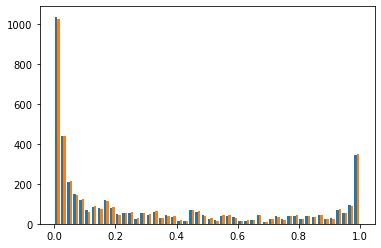

In [19]:
plot_var_hist('Norm_PBind',normed_pbind_df)


In [109]:
curr_lnfracPWM_bychrm= []
for n in range(1,23):
    bgfreqs_n = bgfrac_df.loc[bgfrac_df['Chrm'] == str(n)][['frac_A','frac_C','frac_G','frac_T']]
    curr_lnfracPWM_bychrm.append(get_lnPWM_from_fracPWM(test_fracPWM,bgfreqs_n))

In [23]:

def get_random_bgseqs(slen,reps,fastaloc,chrmsizes,seqinfo_file=None):
    chrms_touse = list(chrmsizes['chrom'])
    bgseq_list = []
    if(seqinfo_file is not None):
        genseqs_df = read_csv(seqinfo_file,delimiter='\t')
        for r,seq in genseqs_df.iterrows():
            chrmfile = '{0}/chr{1}.fa'.format(fastaloc,seq['Chrm'])
            curr_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(seq['Chrm'],seq['Start'],seq['End']),chrmfile)
            bgseq_list.append([seq['Chrm'],seq['Start'],seq['End'],curr_seq.upper()])
    while(len(bgseq_list) < int(reps)):
        is_valid_seq = True
        try:
#             curr_chrm = random.randint(1,22)
            curr_chrm = 8
            curr_start = random.randint(1,chrmsizes.loc[chrmsizes['chrom'] == 'chr{0}'.format(curr_chrm)]['size'].values[0])
            #TODO check for end being over the size of the chrm
            curr_end = curr_start + slen
            chrmfile = '{0}/chr{1}.fa'.format(fastaloc,curr_chrm)
            curr_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(curr_chrm,curr_start,curr_end),chrmfile).upper()
            for b in curr_seq:
                if(b not in 'ACTG'):
                    is_valid_seq = False
                    continue
            if(is_valid_seq):
                bgseq_list.append([curr_chrm,curr_start,curr_end,curr_seq])
        except:
            continue
            # bgseq_list.append({'chrm':curr_chrm,'start':curr_start,'end':curr_end,'seq':curr_seq.upper()})
    return bgseq_list


In [29]:
bgseqs_test = get_random_bgseqs(10,1000,'/local3/jake/TF_binding/testing/',chrmsizes_df)

In [30]:
start=time.time()
outfile_currTF = open('/local3/jake/TF_binding/testing/test_output_seqs.outputfile','w')
outfile_currTF.write('Chrm\tStart\tEnd\n')
for s in bgseqs_test:
    curr_seq = s[3]
    time.sleep(5.18288373947e-05)
    outfile_currTF.write('{0}\t{1}\t{2}\n'.format(s[0],s[1],s[2]))
outfile_currTF.close()
end=time.time()
print('time taken = {0}'.format(end-start))

time taken = 0.15946602821350098


In [34]:
start=time.time()
seqsdf_test = DataFrame(bgseqs_test,columns=['Chrm','Start','End','seq'])
seqsdf_test.to_csv('/local3/jake/TF_binding/testing/test_output_seqs.outputfile_fromdf',sep='\t',columns=['Chrm','Start','End'],index=False)
end=time.time()
print('time taken = {0}'.format(end-start))

time taken = 0.06365561485290527


In [32]:
bgseqs_test

[[8, 24455422, 24455432, 'TATGGCACATA'],
 [8, 85030719, 85030729, 'CTTTAACATGT'],
 [8, 87026425, 87026435, 'ACACAGGATAG'],
 [8, 141101110, 141101120, 'CTCAAGGACTG'],
 [8, 77052724, 77052734, 'TATTCTAATTA'],
 [8, 139516786, 139516796, 'TTAATTACAGC'],
 [8, 16079328, 16079338, 'GGCAGCCTAAG'],
 [8, 52129563, 52129573, 'CAGGCATACTT'],
 [8, 48282966, 48282976, 'AGATAAGCAGA'],
 [8, 80697033, 80697043, 'TCTGAGTTCTA'],
 [8, 137029103, 137029113, 'GAGAATGGTGT'],
 [8, 116871118, 116871128, 'TATGTTTGTTT'],
 [8, 41489368, 41489378, 'AAGCAATTCTC'],
 [8, 131625939, 131625949, 'GAGGCCATTAA'],
 [8, 35321313, 35321323, 'AAAAAAAAAAA'],
 [8, 17500543, 17500553, 'GTGTTCCTAGT'],
 [8, 2561457, 2561467, 'TTGCTCAGGCT'],
 [8, 28250412, 28250422, 'CCGCCTTGGCC'],
 [8, 23994670, 23994680, 'TGGACTTACAG'],
 [8, 67094216, 67094226, 'TTAAAACAGAG'],
 [8, 90388046, 90388056, 'AGGAGACATAA'],
 [8, 27511594, 27511604, 'TGCATCCCATC'],
 [8, 74915186, 74915196, 'TGTTCTCTTGA'],
 [8, 96961639, 96961649, 'GACTCGGACAG'],
 [8, 490

([array([1045.,  442.,  251.,  105.,  118.,   68.,  139.,   60.,   88.,
           85.,   54.,   37.,   56.,   41.,   42.,   58.,   50.,   22.,
           57.,   23.,   16.,   68.,   42.,   46.,   34.,   19.,   38.,
           38.,   52.,   15.,   16.,    9.,   33.,   32.,    5.,   55.,
           11.,   54.,   40.,   18.,   40.,   36.,   38.,   35.,   25.,
           59.,   68.,   84.,  351.]),
  array([1034.,  443.,  257.,   99.,  119.,   63.,  140.,   48.,   89.,
           90.,   48.,   42.,   59.,   40.,   46.,   62.,   47.,   24.,
           60.,   27.,   15.,   66.,   41.,   49.,   35.,   20.,   35.,
           42.,   51.,   15.,   17.,   11.,   35.,   31.,    6.,   49.,
           11.,   52.,   42.,   19.,   41.,   34.,   42.,   33.,   23.,
           64.,   65.,   79.,  358.])],
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.2857142

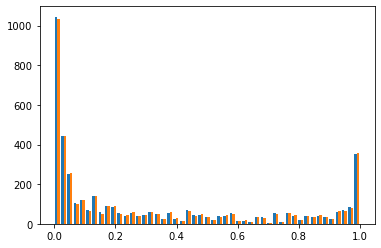

In [17]:
fig,ax = plt.subplots()
bins = np.linspace(0,1)
plt.hist([normed_pbind_df['Norm_PBind (REF)'],normed_pbind_df['Norm_PBind (ALT)']],bins=bins)
# plt.hist(normed_pbind_df['Norm_PBind (ALT)'])

In [41]:
normed_pbind_df

,snp,TF,H (REF),H (ALT),pbind (REF),pbind (ALT),Norm_PBind (REF),Norm_PBind (ALT)
0,3:13308152,TFAP2A(var.2),0.633006,-0.435252,8.768534e-02,2.551912e-01,0.131395,0.113429
1,3:13308152,BARX2,15.359863,9.436166,3.115243e-09,1.164449e-06,0.014385,0.014385
2,3:13308152,Esrrg,10.279685,9.026033,2.620004e-03,9.178180e-03,0.987035,0.986951
3,3:13308152,MEIS2,1.848022,1.381386,1.075637e+00,1.715232e+00,0.699580,0.551245
4,3:13308152,MEIS3,-2.361144,0.190768,1.509059e-01,1.176048e-02,0.012091,0.013871
...,...,...,...,...,...,...,...,...
4213,6:4907848,PBX1,7.282949,7.959959,1.750528e-05,8.895038e-06,0.024842,0.024842
4214,6:4907848,LHX1,11.281669,10.860066,2.079952e-06,3.170685e-06,0.141669,0.141669
4215,6:4907848,ISL2,8.907163,8.738833,3.008563e-06,3.560113e-06,0.021734,0.021734
4216,6:4907848,Dux,26.649268,26.227665,2.794816e-13,4.260427e-13,0.094784,0.094784


In [90]:
def get_seq_combos(seq,al,tf_len):
    seqs_list = []
    complseqs_list = []
    for num in range(tf_len):
        newseq = ''
        curr_ref_start_pos = tf_len-num-1
        curr_ref_end_pos = curr_ref_start_pos+tf_len
        curr_seq = seq[curr_ref_start_pos:curr_ref_end_pos]
        tempseq = ''
        for n,b in enumerate(curr_seq):
            if((n+curr_ref_start_pos) == (tf_len-1)):
                tempseq = ''.join([tempseq,al])
            else:
                tempseq = ''.join([tempseq,b])
        seqs_list.append(tempseq)
        complseqs_list.append(get_complseq(tempseq))
    return seqs_list,complseqs_list


def get_scoredict_entry(seq,pwm,bg_z_df,bgfreqs,tfname,tfpbind_cutoff=None):
    fracPWM = get_fracPWM_from_matrix(pwm)
    lnfracPWM = get_lnPWM_from_fracPWM(fracPWM,bgfreqs)
    rawscore_list = get_matrix_scores(pwm,seq)
    pos_counts = get_matrix_counts(pwm)
    tot_count = sum(pos_counts)
    score_ln = get_matrix_scores(lnfracPWM,seq)
    curr_fracscore = sum([rawscore_list[x]/pos_counts[x] for x in range(len(pos_counts))])
    curr_H = np.sum(score_ln)
    curr_bindingp = calculate_bindingP(curr_H,bg_z_df,tfname)
    if(tfpbind_cutoff is not None):
        if(curr_bindingp >= float(tfpbind_cutoff)):
            curr_scoredict = {'tf_name':tfname,'raw_score':sum(rawscore_list),'tf_len':len(pwm),'counts_perpos':min(pos_counts),
                    'fraction_score':curr_fracscore,'H':curr_H,'bindingP':curr_bindingp}#,'orientation':'+','direction':'forward','motif_pos':p}
    else:
        curr_scoredict = {'tf_name':tfname,'raw_score':sum(rawscore_list),'tf_len':len(pwm),'counts_perpos':min(pos_counts),
                    'fraction_score':curr_fracscore,'H':curr_H,'bindingP':curr_bindingp}
    return curr_scoredict

In [91]:
test_seqlist = get_seq_combos(ref_full_seq,'G',len(curr_matrix))
bgfreqs = bgfrac_df.loc[bgfrac_df['Chrm'] == 'Total'][['frac_A','frac_C','frac_G','frac_T']]

'GCATTCATTAGG'

In [18]:
def get_random_bgseqs(slen,reps,fastaloc,chrmsizes,seqinfo_file=None):
    # x = pybedtools.BedTool()
    chrms_touse = list(chrmsizes['chrom'])
    bgseq_list = []
    if(seqinfo_file is not None):
        genseqs_df = read_csv(seqinfo_file,delimiter='\t')
        for r,seq in genseqs_df.iterrows():
            chrmfile = '{0}/chr{1}.fa'.format(fastaloc,seq['Chrm'])
            curr_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(seq['Chrm'],seq['Start'],seq['End']),chrmfile)
            bgseq_list.append([seq['Chrm'],seq['Start'],seq['End'],curr_seq.upper()])
    while(len(bgseq_list) < int(reps)):
        is_valid_seq = True
        try:
            curr_chrm = 8
            curr_start = random.randint(1,chrmsizes.loc[chrmsizes['chrom'] == 'chr{0}'.format(curr_chrm)]['size'].values[0])
            curr_end = curr_start + slen
            chrmfile = '{0}/chr{1}.fa'.format(fastaloc,curr_chrm)
            curr_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(curr_chrm,curr_start,curr_end),chrmfile).upper()
            for b in curr_seq:
                if(b not in 'ACTG'):
                    is_valid_seq = False
                    continue
            if(is_valid_seq):
                bgseq_list.append([curr_chrm,curr_start,curr_end,curr_seq])
        except:
            continue
            # bgseq_list.append({'chrm':curr_chrm,'start':curr_start,'end':curr_end,'seq':curr_seq.upper()})
    return bgseq_list

In [36]:
get_random_bgseqs(10,5,'/local3/jake/TF_binding/testing',chrmsizes_df)

[[8, 99052390, 99052400, 'TGAAAAAAACT'],
 [8, 35673058, 35673068, 'TGGTGAGTGAG'],
 [8, 114551456, 114551466, 'AAACATTCTAA'],
 [8, 4262645, 4262655, 'ATTGGTTATTT'],
 [8, 40835500, 40835510, 'GTTGGCCAGGC']]

In [38]:
# test_finaloutput_df = read_csv('/local3/jake/TF_binding/testing/final_PWM.alltraits.allsnps.withPBinding100reps.output',delimiter='\t')
test_finaloutput_df = read_csv('/local3/jake/TF_binding/testing/final_PWM.alltraits.allsnps.withPBinding100reps.output',delimiter='\t')


In [61]:
count = 0
for i,p in test_finaloutput_df.iterrows():
    if(p['P binding (REF)'] > 1):
        curr_z = bg_z_df.loc[bg_z_df['TF_name'] == p['TF_name']]['BG Z score'].values[0]
        print(p['P binding (REF)'],p['TF_name'],math.exp(-p['H (REF)'])/(curr_z+math.exp(-p['H (REF)'])))
        count += 1
        
        

1.07563699327 MEIS2 0.5182201881921262
14.7703128976 FOXC2 0.9365897172428472
6.6773563475 HOXD9 0.8697468301927145
1.55498734326 Znf281 0.6086086286742479
387.908761496 Foxo1 0.997428702824405
1.38167730713 FOXC2 0.5801278380550885
6.03604829404 NKX2-2 0.857874767452769
7.434444318200001 NKX2-3 0.8814385438719917
7.72985977408 GCM2 0.8854506228185611
134.608632857 IRF6 0.9926258382012114
1.25819402688 MZF1(var.2) 0.5571682556505344
2008.59665436 TBX1 0.9995023877065943
20.7294432022 TBX15 0.9539794926774795
151.173459035 NKX2-2 0.9934285518227927
435.24958535 ZNF384 0.9977077342109218
55.4901279226 NFAT5 0.9822977919013617
4.79641804599 ZBTB7C 0.8274796620831028
348350.756348 KLF14 0.9999971293384294
284.893105939 ZNF740 0.9965021891775955
11612.9830514 ZNF148 0.9999138968951843
3.693068696 TFAP2A(var.3) 0.7869198034854442
10.2753420248 TFAP2C 0.9113108943573858
84.78731061069999 GCM2 0.9883432643723044
1.38167730713 FOXC2 0.5801278380550885
6.03604829404 NKX2-2 0.857874767452769
7.43

In [58]:
count

118

In [48]:
test_finaloutput_df.loc[test_finaloutput_df['P binding (REF)'] > 1]

,chr,pos,snp_id,pvalue,beta,ref_allele,alt_allele,trait_num,TF_name,PWM_fracscore_ref,PWM_fracscore_alt,TF_len,TF_count,H (REF),Hprime (ALT),P binding (REF),P binding (ALT)
3,3,13308152,3:13308152,1.252538e-11,6.312838,C,A,6,MEIS2,4.472486,4.498092,8,1355.0,1.848022,1.381386,1.075637,1.715232
37,9,117741852,9:117741852,3.720925e-10,8.344869,A,G,6,FOXC2,6.312845,5.851529,12,20559.0,-3.212667,-1.366008,14.770313,2.330214
72,4,36936148,4:36936148,1.048648e-08,7.487932,C,T,6,HOXD9,5.371421,5.368861,10,16367.0,3.687649,7.927654,6.677356,0.096204
135,2,75543351,2:75543351,2.109130e-08,6.243562,G,A,6,Znf281,5.801887,5.795648,11,6572.0,2.039124,2.557725,1.554987,0.925766
149,3,78699639,3:78699639,1.260930e-09,6.238320,C,T,7,Foxo1,5.876905,5.872895,11,2494.0,0.032564,0.471262,387.908761,250.152886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,10,101227322,10:101227322,7.738416e-09,4.733058,G,A,24,KLF5,4.566361,3.802130,10,13615.0,5.514446,7.867854,1.356341,0.128913
4089,21,37815373,21:37815373,9.301903e-09,6.797307,C,T,24,HES1,4.075568,4.075568,10,18530.0,2.791947,2.791947,2.576825,2.576825
4104,6,161296413,6:161296413,1.050335e-08,2.978600,C,T,24,ZBTB14,5.336410,6.323006,12,4551.0,0.897615,-4.694942,3.269063,877.485065
4140,12,125145063,12:125145063,4.790847e-01,0.535178,G,C,24,KLF4,7.116014,6.262822,12,55821.0,-7.345788,-3.910319,2.561370,0.082502


In [40]:
bg_z_df.loc[bg_z_df['TF_name'] == 'TFAP2A(var.2)']

,TF_name,BG Z score
318,TFAP2A(var.2),6.055668


'GGATTACTTACAGTTAAACGTAA'

In [67]:
''.join(list(reversed(ref_full_seq))) == get_rev_seq(ref_full_seq)

True

In [62]:
print(ref_full_seq)
seqlist = []
for n in range(tf_len):
    newseq = ''
    curr_ref_start_pos = tf_len-n-1
    curr_ref_end_pos = curr_ref_start_pos+tf_len
    print((curr_ref_start_pos),(tf_len-1),curr_ref_end_pos)
    curr_seq = ref_full_seq[curr_ref_start_pos:curr_ref_end_pos]
    print(curr_seq,len(curr_seq))
    seqlist.append([curr_seq,curr_ref_start_pos])
#     for s in ref_full_seq

new_seqlist = []
al = 'A'
for s in seqlist:
    tempseq = ''
    for n,b in enumerate(s[0]):
        if((n+s[1]) == (tf_len-1)):
            tempseq = ''.join([tempseq,al])
        else:
            tempseq = ''.join([tempseq,b])
    new_seqlist.append(tempseq)

AATGCAAATTGACATTCATTAGG
11 11 23
ACATTCATTAGG 12
10 11 22
GACATTCATTAG 12
9 11 21
TGACATTCATTA 12
8 11 20
TTGACATTCATT 12
7 11 19
ATTGACATTCAT 12
6 11 18
AATTGACATTCA 12
5 11 17
AAATTGACATTC 12
4 11 16
CAAATTGACATT 12
3 11 15
GCAAATTGACAT 12
2 11 14
TGCAAATTGACA 12
1 11 13
ATGCAAATTGAC 12
0 11 12
AATGCAAATTGA 12


In [ ]:
for num in range(tf_len):
    newseq = ''
    curr_ref_start_pos = tf_len-num-1
    curr_ref_end_pos = curr_ref_start_pos+tf_len
    curr_seq = seq[curr_ref_start_pos:curr_ref_end_pos]
    print((curr_ref_start_pos),(tf_len-1),curr_ref_end_pos)
    tempseq = ''
    for n,b in enumerate(curr_seq):
        if((n+curr_ref_start_pos) == (tf_len-1)):
            tempseq = ''.join([tempseq,al])
        else:
            tempseq = ''.join([tempseq,b])
    seqs_list.append(tempseq)
    complseqs_list.append(get_complseq(tempseq))

In [11]:
# gene_df = read_csv('/local3/jake/TF_binding/testing/14.5M.TopVars.LE.chrm8.pos61768012.TF_genes',header=None,delimiter='\t')
# gene_df.columns = ['pos_start','pos_end','tf_name']
position = 61768012
chromosome = 8
ref_pos_end = max(gene_df['pos_end'])
ref_pos_start = min(gene_df['pos_start'])
gene_df['relative_start'] =  gene_df['pos_start']-ref_pos_start
gene_df['relative_end'] = gene_df['pos_end']-ref_pos_start

matrix_loc = '/local3/jake/TF_binding/JASPAR2020_CORE_vertebrates_non-redundant_pfms_transfac/'
# matrix_loc = 'gene_dfJASPAR2020_CORE_vertebrates_non-redundant_pfms_transfac'
transfac_matrix_list = os.listdir(matrix_loc)
infodicts_list = []
for f in transfac_matrix_list:
    curr_infodict = read_JASPAR_transfac_pfms('{0}/{1}'.format(matrix_loc,f))
    infodicts_list.append(curr_infodict)
    
# for i,g in gene_df.iterrows():
#     curr_score = get_matrix_byTFName(g[2],infodicts_list,'ACT')
#     print('score for {0} is {1}'.format(g[2],curr_score))
    

# ref_full_seq = get_hg19reference_sequence(ref_pos_start,ref_pos_end,'/local3/jake/TF_binding/chr4.fa')
ref_full_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(8,ref_pos_start,(ref_pos_end)),'/local3/jake/TF_binding/testing/chr8.fa')

updated_pos = (position-ref_pos_start)

NameError: name 'gene_df' is not defined

In [21]:
bgfrac_df = read_csv('/local3/jake/TF_binding/ACTG_count.all_chrms.fractions.txt',delimiter='\t')
score_dict_bytf ={}
for i,g in gene_df.iterrows():
    curr_relative_pos = abs(updated_pos-g['relative_start'])
    curr_refseq = make_seq(ref_full_seq[g['relative_start']:(g['relative_end']+1)],curr_relative_pos,'G')
    curr_altseq = make_seq(ref_full_seq[g['relative_start']:(g['relative_end']+1)],curr_relative_pos,'A')
    curr_matrix = get_matrix_byTF(g['tf_name'],infodicts_list)
    curr_fracPWM = get_fracPWM_from_matrixdict(curr_matrix)
    curr_lnfracPWM = get_fraclnPWM_from_matrixdict(curr_matrix)
    # curr_refscore,curr_altscore,curr_counts = get_matrix_scores(tfname=g['tf_name'],matrix_dict=curr_matrix,ref_al=args.ref_al,alt_al=args.alt_al,position=curr_relative_pos,reference_seq=curr_seq)
    # curr_totcount = sum(curr_counts)
    refscore_list = get_matrix_scores(curr_matrix,curr_refseq)
    altscore_list = get_matrix_scores(curr_matrix,curr_altseq)
    pos_counts = get_matrix_counts(curr_matrix,curr_matrix['TF_len'])
    tot_count = sum(pos_counts)
    curr_scoredict = {'ref_score':sum(refscore_list),'alt_score':sum(altscore_list),'tf_len':curr_matrix['TF_len'],'counts_perpos':min(pos_counts)}
    curr_scoredict['ref_fraction_score'] = sum([refscore_list[x]/pos_counts[x] for x in range(len(pos_counts))])
    curr_scoredict['alt_fraction_score'] = sum([altscore_list[x]/pos_counts[x] for x in range(len(pos_counts))])

    refscore_ln = get_matrix_scores(curr_lnfracPWM,curr_refseq)
    altscore_ln = get_matrix_scores(curr_lnfracPWM,curr_altseq)
    curr_scoredict['ref_fraction_ln_score'] = sum(refscore_ln)
    curr_scoredict['alt_fraction_ln_score'] = sum(altscore_ln)

    # frac_refvals,frac_altvals = get_frac_matrix_scores(tfname=g['tf_name'],pwm=curr_fracPWM,ref_al=args.ref_al,alt_al=args.alt_al,position=curr_relative_pos,reference_seq=curr_seq)
    # fracln_refvals,fracln_altvals = get_frac_matrix_scores(tfname=g['tf_name'],pwm=curr_lnfracPWM,ref_al=args.ref_al,alt_al=args.alt_al,position=curr_relative_pos,reference_seq=curr_seq)
    bgfreqs = np.array(bgfrac_df.loc[bgfrac_df['Chrm'] == str(chromosome)][['frac_A','frac_C','frac_G','frac_T']])
    ref_Y = compute_Y(curr_refseq,bgfreqs)
    alt_Y = compute_Y(curr_altseq,bgfreqs)
    ref_H = refscore_ln - ref_Y
    alt_H = altscore_ln - alt_Y
    curr_scoredict['H'] = np.sum(ref_H)
    curr_scoredict['Hprime'] = np.sum(alt_H)

    score_dict_bytf[g['tf_name']] = curr_scoredict
    

NameError: name 'gene_df' is not defined

In [66]:
seqA = 'AAAAAAAAAAAAAA'
seqB = 'GAAAAAAAAAAAAA'
curr_matrix = read_JASPAR_transfac_pfms('/local3/jake/TF_binding/TF_1.transfac')
bgfreqs = bgfrac_df.loc[bgfrac_df['Chrm'] == 'Total'][['frac_A','frac_C','frac_G','frac_T']]
# curr_lnfracPWM = get_fraclnPWM_from_matrixdict(curr_matrix)
curr_fracPWM = get_fracPWM_from_matrixdict(curr_matrix)
curr_lnfracPWM = get_lnPWM_from_fracPWM(curr_fracPWM,bgfreqs)
Ascore_ln = get_matrix_scores(curr_lnfracPWM,seqA)
Bscore_ln = get_matrix_scores(curr_lnfracPWM,seqB)

A_Y = compute_Y(seqA,np.array(bgfreqs))
B_Y = compute_Y(seqB,np.array(bgfreqs))
A_H = Ascore_ln - A_Y
B_H = Bscore_ln - B_Y

In [162]:
# sum_A = np.sum(bgfrac_df['count_A'])
# sum_C = np.sum(bgfrac_df['count_C'])
# sum_G = np.sum(bgfrac_df['count_G'])
# sum_T = np.sum(bgfrac_df['count_T'])
# sum_total = np.sum(bgfrac_df['total'])
# bgfrac_df = bgfrac_df.append({'Chrm':'Total','count_A':sum_A,'count_C':sum_C,'count_G':sum_G,'count_T':sum_T,'total':sum_total,'frac_A':(sum_A/sum_total),'frac_C':(sum_C/sum_total),'frac_G':(sum_G/sum_total),'frac_T':(sum_T/sum_total)},ignore_index=True)
np.array(bgfrac_df.loc[bgfrac_df['Chrm'] == 8][['frac_A','frac_C','frac_G','frac_T']])


array([], shape=(0, 4), dtype=float64)

In [41]:
bgfrac_df

,Chrm,count_A,count_C,count_G,count_T,total,frac_A,frac_C,frac_G,frac_T
0,1,65570891,47024412,47016562,65668756,2.252806e+08,0.291063,0.208737,0.208702,0.291498
1,2,71102632,47915465,47947042,71239379,2.382045e+08,0.298494,0.201153,0.201285,0.299068
2,3,58713343,38653197,38670110,58760485,1.947971e+08,0.301408,0.198428,0.198515,0.301650
3,4,57932980,35885806,35890822,57952068,1.876617e+08,0.308710,0.191226,0.191253,0.308811
4,5,53672554,35089383,35129186,53804137,1.776953e+08,0.302048,0.197469,0.197693,0.302789
5,6,50554433,33143287,33163423,50533923,1.673951e+08,0.302007,0.197994,0.198115,0.301884
6,7,45997757,31671670,31636979,46047257,1.553537e+08,0.296084,0.203868,0.203645,0.296403
7,8,42767293,28703983,28702621,42715025,1.428889e+08,0.299304,0.200883,0.200874,0.298939
8,9,35260078,24826212,24813259,35243882,1.201434e+08,0.293483,0.206638,0.206530,0.293348
9,10,38330752,27308648,27298423,38376915,1.313147e+08,0.291900,0.207963,0.207885,0.292251


In [36]:
test_mat = get_matrix_byTF('TEF',infodicts_list)
test_fracmat = get_fracPWM_from_matrix(test_mat)
test_lnfracmat = get_lnPWM_from_fracPWM(test_fracmat,bgfrac_df.loc[bgfrac_df['Chrm'] == 'Total'])

In [32]:
bgfreqs = bgfrac_df.loc[bgfrac_df['Chrm'] == 'Total']

In [37]:
test_lnfracmat

[{'A': 0.6735225273982176,
  'C': -0.3554471495320632,
  'T': -0.08175289925020757,
  'G': -0.14459640764447515},
 {'A': -0.5177994648194508,
  'C': 0.7835377014306947,
  'T': 4.873093687874733,
  'G': -0.6913982749716533},
 {'A': 2.4887931408833537,
  'C': 3.691325718965144,
  'T': -1.188277683467875,
  'G': 4.844439435478379},
 {'A': 2.3242229598990236,
  'C': 6.642466237754624,
  'T': -1.1815761438448353,
  'G': 3.1771645415297476},
 {'A': -1.190937592440007,
  'C': 6.634418984027275,
  'T': 6.999621128163717,
  'G': 1.9435053083729816},
 {'A': 4.1992464783911005,
  'C': -1.463514238717256,
  'T': 0.9883738365415188,
  'G': 6.726164493593496},
 {'A': -0.22037920958245874,
  'C': 6.604900579569244,
  'T': 6.970102723705686,
  'G': -1.1257183578630328},
 {'A': 7.016455283009747,
  'C': 1.7547275337902164,
  'T': -1.1714750478583316,
  'G': 2.868811906397717},
 {'A': -1.1539257019909293,
  'C': 2.3276254526226685,
  'T': 1.9490366833804107,
  'G': 4.186958431263203},
 {'A': -1.21244379

In [14]:
results_loc = '/local3/jake/TF_binding/tophit_SNPs/output_v2/'
pwmresults_list = os.listdir(results_loc)

assocfile_loc = '/local3/mhansen/Projects/CTA/Analysis/GWAS/All_Inds/Results/5M_Filtered'
infofile_loc = '/local3/jake/TF_binding/tophit_SNPs/'
infofile_list = os.listdir(infofile_loc)

final_df_dictlist = []
for i in infofile_list:
    if('.full_assoc' not in i):
        continue
    curr_df = read_csv('{0}{1}'.format(infofile_loc,i),delimiter='\t')
    curr_prefix = '.'.join(i.split('.')[:-1])
    temp_dict = {}
    for num,snp in curr_df.iterrows():
        temp_dict['chr'] = snp['#Chr']
        temp_dict['pos'] = snp['Pos']
        temp_dict['snp_id'] = snp['VID']
        temp_dict['beta'] = snp['Beta']
        temp_dict['pvalue'] = snp['pval']
        temp_dict['ref_allele'] = snp['Ref']
        temp_dict['alt_allele'] = snp['Alt']
        temp_dict['trait_num'] = curr_prefix.split('.')[0]
        curr_pwmfile = '{0}{1}.chrm{2}.pos{3}.PWM_scores'.format(results_loc,curr_prefix,snp['#Chr'],snp['Pos'])
        

FileNotFoundError: [Errno 2] No such file or directory: '/local3/jake/TF_binding/tophit_SNPs/output_v2/'

In [17]:
test_pwmfile = '24.5M.TopVars.LE.chrm4.pos165034923.PWM_scores'
# position = int(args.position.split(':')[1])
position = 165034923
# chromosome = int(args.position.split(':')[0])
chromosome = 4

# gene_df = read_csv('{0}'.format(args.input_gene_file),header=None,delimiter='\t')
gene_df = read_csv('/local3/jake/TF_binding/tophit_SNPs/output/24.5M.TopVars.LE.chrm4.pos165034923.TF_genes',header=None,delimiter='\t')
gene_df.columns = ['pos_start','pos_end','tf_name']
# transfac_matrix_list = os.listdir(args.matrix_loc)
matrix_loc = '/local3/jake/TF_binding/JASPAR2020_CORE_vertebrates_non-redundant_pfms_transfac/'
# matrix_loc = 'gene_dfJASPAR2020_CORE_vertebrates_non-redundant_pfms_transfac'
transfac_matrix_list = os.listdir(matrix_loc)
infodicts_list = []
for f in transfac_matrix_list:
    curr_infodict = read_JASPAR_transfac_pfms('{0}/{1}'.format(matrix_loc,f))
    infodicts_list.append(curr_infodict)

ref_pos_end = max(gene_df['pos_end'])
ref_pos_start = min(gene_df['pos_start'])
# ref_full_seq = get_hg19reference_sequence(ref_pos_start,ref_pos_end,args.ref_fasta_file)
ref_full_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(chromosome,ref_pos_start,ref_pos_end),args.ref_fasta_file)
updated_pos = (position-ref_pos_start)
gene_df['relative_start'] =  gene_df['pos_start']-ref_pos_start
gene_df['relative_end'] = gene_df['pos_end']-ref_pos_start

score_dict_bytf ={}
for i,g in gene_df.iterrows():
    curr_relative_pos = abs(updated_pos-g['relative_start'])
    curr_seq = ref_full_seq[g['relative_start']:(g['relative_end']+1)]
    curr_matrix = get_matrix_byTF(g['tf_name'],infodicts_list)
    curr_refscore,curr_altscore,curr_counts = get_matrix_scores(tfname=g['tf_name'],matrix_dict=curr_matrix,ref_al=args.ref_al,alt_al=args.alt_al,position=curr_relative_pos,reference_seq=curr_seq)
    curr_totcount = sum(curr_counts)
    score_dict_bytf[g['tf_name']] = {'ref_score':curr_refscore,'alt_score':curr_altscore,'ref_fraction_score':(curr_refscore/curr_totcount),'alt_fraction_score':(curr_altscore/curr_totcount),'tf_len':len(curr_seq),'counts_perpos':curr_counts[0]}


NameError: name 'args' is not defined

In [22]:
#Make the final results df; combining the different .PWM output files
results_loc = '/local3/jake/TF_binding/testing/tophit_SNPs/output_v5/'
pwmresults_list = os.listdir(results_loc)

assocfile_loc = '/local3/mhansen/Projects/CTA/Analysis/GWAS/All_Inds/Results/5M_Filtered'
infofile_loc = '/local3/jake/TF_binding/testing/tophit_SNPs/'
infofile_list = os.listdir(infofile_loc)

final_df_dictlist = []
for i in infofile_list:
    if('.full_assoc' not in i):
        continue
    elif(i == '8.1M_5M.TopVars.LE.5M.full_assoc' or i == '7.1M_5M.TopVars.LE.5M.full_assoc'):
        continue
    curr_df = read_csv('{0}{1}'.format(infofile_loc,i),delimiter='\t')
    curr_prefix = '.'.join(i.split('.')[:-1])
    temp_dict = {}
    for num,snp in curr_df.iterrows():
        temp_dict['chr'] = snp['#Chr']
        temp_dict['pos'] = snp['Pos']
        temp_dict['snp_id'] = snp['VID']
        if(i == '8.1M_5M.TopVars.LE.full_assoc' or i == '7.1M_5M.TopVars.LE.full_assoc' ):
            temp_dict['beta'] = snp['Beta_FE']
            temp_dict['pvalue'] = snp['pval_FE']
            if(i == '8.1M_5M.TopVars.LE.full_assoc'):
                d = read_csv('{0}{1}'.format(infofile_loc,'8.1M_5M.TopVars.LE.5M.full_assoc'),delimiter='\t')
                temp_dict['ref_allele'] = d.loc[num]['Ref']
                temp_dict['alt_allele'] = d.loc[num]['Alt']
            if(i == '7.1M_5M.TopVars.LE.full_assoc'):
                d = read_csv('{0}{1}'.format(infofile_loc,'7.1M_5M.TopVars.LE.5M.full_assoc'),delimiter='\t')
                temp_dict['ref_allele'] = d.loc[num]['Ref']
                temp_dict['alt_allele'] = d.loc[num]['Alt']
        else:
            temp_dict['pvalue'] = snp['pval']
            temp_dict['beta'] = snp['Beta']
            temp_dict['ref_allele'] = snp['Ref']
            temp_dict['alt_allele'] = snp['Alt']
        temp_dict['trait_num'] = curr_prefix.split('.')[0]
        curr_pwmfile = '{0}{1}.chrm{2}.pos{3}.PWM_scores'.format(results_loc,curr_prefix,snp['#Chr'],snp['Pos'])
        curr_pwm_df = read_csv(curr_pwmfile,skiprows=1,delimiter='\t')
        for index,tf in curr_pwm_df.iterrows():
            curr_dict = temp_dict.copy()
            curr_dict['TF_name'] = tf['TF_Name']
            curr_dict['PWM_fracscore_ref'] = tf['PWM Fraction Score (REF allele)'] #f(float(tf['PWM Fraction Score (REF allele)']),5)#"{0:.5f}".format(tf['PWM Fraction Score (REF allele)'])
            curr_dict['PWM_fracscore_alt'] = tf['PWM Fraction Score (ALT allele)'] #f(float(tf['PWM Fraction Score (Alt allele)']),5)#"{0:.5f}".format(tf['PWM Fraction Score (ALT allele)'])
            curr_dict['TF_len'] = tf['TF Length']
            curr_dict['TF_count'] = tf['TF Counts per position']
#             curr_dict['PWM_ln_fracscore_ref'] = "{0:.5f}".format(tf['REF Log(PWM Fraction Score)'])
#             curr_dict['PWM_ln_fracscore_alt'] = "{0:.5f}".format(tf['ALT Log(PWM Fraction Score)'])
            curr_dict['H (REF)'] = tf['H (REF)'] #f(float(tf['H (REF)']),5)#"{0:.5f}".format(tf['H (REF)'])
            curr_dict['Hprime (ALT)'] = tf['Hprime (ALT)'] #f(float(tf['Hprime (ALT)']),5)#"{0:.5f}".format(tf['Hprime (ALT)'])
            curr_dict['P binding (REF)'] = tf['P binding (REF)'] #f(float(tf['P binding (REF)']),5)#"{0:.5f}".format(tf['P binding (REF)'])
            curr_dict['P binding (ALT)'] = tf['P binding (ALT)'] #f(float(tf['P binding (ALT)']),5)#"{0:.5f}".format(tf['P binding (ALT)'])
            final_df_dictlist.append(curr_dict)

final_df = DataFrame(final_df_dictlist)



In [38]:
final_df.loc[final_df['P binding (REF)'] > 100]


,chr,pos,snp_id,pvalue,beta,ref_allele,alt_allele,trait_num,TF_name,PWM_fracscore_ref,PWM_fracscore_alt,TF_len,TF_count,H (REF),Hprime (ALT),P binding (REF),P binding (ALT)
149,3,78699639,3:78699639,1.260930e-09,6.238320,C,T,7,Foxo1,5.876905,5.872895,11,2494.0,0.032564,0.471262,387.908761,250.152886
328,15,48683454,15:48683454,8.597562e-12,2.115559,T,G,25,IRF6,5.044620,5.028799,9,2665.0,0.344800,2.130402,134.608633,22.573342
433,11,61137147,11:61137147,7.483225e-10,2.144577,T,A,25,TBX1,5.015816,4.020404,8,11935.0,-1.666418,7.720827,2008.596654,0.168292
443,15,28238895,15:28238895,8.381399e-10,2.188545,A,G,25,NKX2-2,7.162255,7.162255,14,26027.0,-5.118098,-5.118098,151.173459,151.173459
523,15,48296524,15:48296524,1.368194e-08,1.720186,C,T,25,ZNF384,7.695108,7.765220,12,30437.0,-7.035665,-6.987407,435.249585,414.744055
775,14,59697005,14:59697005,5.008992e-09,0.975950,G,A,20,KLF14,7.611608,7.609984,14,1604.0,-6.209140,-5.690172,348350.756348,207315.553111
776,14,59697005,14:59697005,5.008992e-09,0.975950,G,A,20,ZNF740,7.570647,6.623519,13,1059.0,-3.911958,0.590858,284.893106,3.155977
777,14,59697005,14:59697005,5.008992e-09,0.975950,G,A,20,ZNF148,7.317058,6.585022,12,11203.0,-7.368900,-4.846557,11612.983051,932.189034
984,15,48683454,15:48683454,8.913702e-11,1.348175,T,G,26,IRF6,5.044620,5.028799,9,2665.0,0.344800,2.130402,134.608633,22.573342
1041,15,28238895,15:28238895,5.209608e-10,1.485306,A,G,26,NKX2-2,7.162255,7.162255,14,26027.0,-5.118098,-5.118098,151.173459,151.173459


In [ ]:
bg_

In [34]:
final_df.to_csv('/local3/jake/TF_binding/testing/tophit_SNPs/final_PWM.alltraits.allsnps.withPBinding.output',sep='\t',index=False)


In [13]:
import decimal

def float_to_decimal(f):
    # http://docs.python.org/library/decimal.html#decimal-faq
    "Convert a floating point number to a Decimal with no loss of information"
    n, d = f.as_integer_ratio()
    numerator, denominator = decimal.Decimal(n), decimal.Decimal(d)
    ctx = decimal.Context(prec=60)
    result = ctx.divide(numerator, denominator)
    while ctx.flags[decimal.Inexact]:
        ctx.flags[decimal.Inexact] = False
        ctx.prec *= 2
        result = ctx.divide(numerator, denominator)
    return result 

def f(number, sigfig):
    # http://stackoverflow.com/questions/2663612/nicely-representing-a-floating-point-number-in-python/2663623#2663623
    assert(sigfig>0)
    try:
        d=decimal.Decimal(number)
    except TypeError:
        d=float_to_decimal(float(number))
    sign,digits,exponent=d.as_tuple()
    if len(digits) < sigfig:
        digits = list(digits)
        digits.extend([0] * (sigfig - len(digits)))    
    shift=d.adjusted()
    result=int(''.join(map(str,digits[:sigfig])))
    # Round the result
    if len(digits)>sigfig and digits[sigfig]>=5: result+=1
    result=list(str(result))
    # Rounding can change the length of result
    # If so, adjust shift
    shift+=len(result)-sigfig
    # reset len of result to sigfig
    result=result[:sigfig]
    if shift >= sigfig-1:
        # Tack more zeros on the end
        result+=['0']*(shift-sigfig+1)
    elif 0<=shift:
        # Place the decimal point in between digits
        result.insert(shift+1,'.')
    else:
        # Tack zeros on the front
        assert(shift<0)
        result=['0.']+['0']*(-shift-1)+result
    if sign:
        result.insert(0,'-')
    return ''.join(result)

In [36]:
genomesize_file = open('/local3/jake/TF_binding/genomesize.all_chrms.hg19.txt','w')
for row,c in bgfrac_df.iterrows():
    genomesize_file.write('chr{0}\t{1}\n'.format(int(c['Chrm']),int(c['total'])))

genomesize_file.close()

In [28]:
ref_full_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(chromosome,ref_pos_start,ref_pos_end),'/local3/jake/TF_binding/chr8.fa')
tfname_list = list(set(final_df['TF_name']))


In [51]:
test_vals = []

TypeError: decorated() missing 1 required positional argument: 'self'

In [50]:
'{0}/{1}.fa'.format(ref_fasta_loc,'chr8')

'/local3/jake/TF_binding/testing/chr8.fa'

In [96]:
bg_H_by_TF = {}
for f in transfac_matrix_list:
    curr_matrix = read_JASPAR_transfac_pfms('{0}/{1}'.format(matrix_loc,f))
    bgseqs = get_random_bgseqs(curr_matrix['TF_len'],2,ref_fasta_loc,chrmsizes_df)
    
    bg_H_list = []
    for s in bgseqs:
        curr_seq = s['seq']
        bgfreqs = bgfrac_df.loc[bgfrac_df['Chrm'] == str(s['chrm'])][['frac_A','frac_C','frac_G','frac_T']]
        curr_fracPWM = get_fracPWM_from_matrixdict(curr_matrix)
        curr_lnfracPWM = get_lnPWM_from_fracPWM(curr_fracPWM,bgfreqs)
        curr_H = np.sum(get_matrix_scores(curr_lnfracPWM,curr_seq))
        bg_H_list.append(curr_H)
    curr_z = [pow(math.e,-x) for x in bg_H_list]
    bg_H_by_TF[curr_matrix['Matrix_Name']] = sum(curr_z)


In [100]:
bg_Z_byTF = {}
for tf,h in bg_H_by_TF.items():
    curr_z = [pow(math.e,-x) for x in h]
    bg_Z_byTF[tf] = sum(curr_z)

In [27]:
bgseqs = get_random_bgseqs(10,5,'/local3/jake/TF_binding')
bg_H_list = []
bg_H_by_TF = {}
for s in bgseqs:
    curr_seq = s['seq']
    curr_matrix = get_matrix_byTF('TEF',infodicts_list)
    bgfreqs = bgfrac_df.loc[bgfrac_df['Chrm'] == '8'][['frac_A','frac_C','frac_G','frac_T']]
    curr_fracPWM = get_fracPWM_from_matrixdict(curr_matrix)
    curr_lnfracPWM = get_lnPWM_from_fracPWM(curr_fracPWM,bgfreqs)
    curr_H = np.sum(get_matrix_scores(curr_lnfracPWM,curr_seq))
    bg_H_list.append(curr_H)
#     bg_H_list.append()
bg_H_by_TF['TEST_TF'] = bg_H_list

In [26]:
infodicts_list

[{'Matrix_ID': 'MA0843.1',
  'Matrix_Name': 'TEF',
  1: {'A': 542.0, 'C': 1054.0, 'G': 854.0, 'T': 1155.0},
  2: {'A': 1972.0, 'C': 373.0, 'G': 1631.0, 'T': 9.0},
  3: {'A': 91.0, 'C': 19.0, 'G': 6.0, 'T': 3602.0},
  4: {'A': 108.0, 'C': 1.0, 'G': 32.0, 'T': 3602.0},
  5: {'A': 3602.0, 'C': 1.0, 'G': 109.0, 'T': 1.0},
  6: {'A': 18.0, 'C': 3602.0, 'G': 1.0, 'T': 447.0},
  7: {'A': 1325.0, 'C': 1.0, 'G': 2278.0, 'T': 1.0},
  8: {'A': 1.0, 'C': 134.0, 'G': 44.0, 'T': 3602.0},
  9: {'A': 3602.0, 'C': 77.0, 'G': 12.0, 'T': 162.0},
  10: {'A': 3602.0, 'C': 1.0, 'G': 20.0, 'T': 11.0},
  11: {'A': 1.0, 'C': 2121.0, 'G': 270.0, 'T': 1482.0},
  12: {'A': 1384.0, 'C': 1142.0, 'G': 555.0, 'T': 523.0},
  'tax_group': 'vertebrates',
  'TF_len': 12,
  'tf_family': 'TEF-1-related',
  'tf_class': 'TEA',
  'pubmed_ids': '25215497',
  'uniprot_ids': 'Q10587',
  'data_type': 'HT-SELEX'},
 {'Matrix_ID': 'MA0715.1',
  'Matrix_Name': 'PROP1',
  1: {'A': 64.0, 'C': 13.0, 'G': 11.0, 'T': 576.0},
  2: {'A': 57

In [19]:
test_TFNAME = "TEF"

tfs_to_check = []
try:
    tf_list_file = open(test_TFNAME,'r')
    for line in tf_list_file:
        tfs_to_check.append(line.split('\n'))
except FileNotFoundError:
    tfs_to_check.append(test_TFNAME)

In [27]:
# for i in infodicts_list:
#     print(i['Matrix_Name'],i['TF_len'])
bg_z_df = read_csv('/local3/jake/TF_binding/backgroundZ_forTFs.100reps.txt',delimiter='\t',skiprows=1)

In [28]:
bg_z_df.loc[bg_z_df['TF_name'] == 'ZNF148']

,TF_name,BG Z score
134,ZNF148,0.136562


(array([741.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.67639196e-11, 1.27126115e+03, 2.54252230e+03, 3.81378344e+03,
        5.08504459e+03, 6.35630574e+03, 7.62756689e+03, 8.89882803e+03,
        1.01700892e+04, 1.14413503e+04, 1.27126115e+04]),
 <a list of 10 Patch objects>)

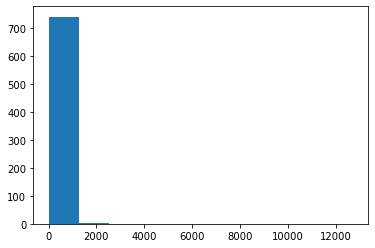

In [47]:
import matplotlib.pyplot as plt
plt.hist(bg_z_df['BG Z score'])

In [21]:
# calculate_bindingP(9.85326613035509,bg_z_df,'NFATC1')
np.

3.4360282958021792e-06

In [111]:
for i,g in gene_df.iterrows():
    curr_relative_pos = abs(updated_pos-g['relative_start'])
    curr_seq = ref_full_seq[g['relative_start']:(g['relative_end']+1)]
    
    curr_matrix = get_matrix_byTF(g['tf_name'],infodicts_list)
#     print(curr_matrix,curr_seq)
    curr_refscore,curr_altscore = get_matrix_scores(tfname=g['tf_name'],matrix_dict=curr_matrix,ref_al='T',alt_al='G',position=curr_relative_pos,reference_seq=curr_seq)
#     print(g['tf_name'],curr_refscore,curr_altscore)
#     print((g['pos_start']-ref_pos_start),(g['pos_end']-ref_pos_start),""(position-ref_pos_start))
#     print(g['pos_start'],g['pos_end'],position)
#     print(g['relative_start'],g['relative_end'],curr_relative_pos,updated_pos)
    print(curr_seq,curr_seq[curr_relative_pos])

ValueError: too many values to unpack (expected 2)

In [201]:
for tf,scores in sorted(score_dict_bytf.items(), key=lambda k_v: k_v[1]['alt_score'],reverse=True):
    print(tf,scores)

OTX2 {'ref_score': 264488.0, 'alt_score': 148783.0}
KLF5 {'ref_score': 72298.0, 'alt_score': 72429.0}
NR2C2(var.2) {'ref_score': 28556.0, 'alt_score': 47184.0}
PITX1 {'ref_score': 41886.0, 'alt_score': 31355.0}
RHOXF1 {'ref_score': 40212.0, 'alt_score': 29296.0}
NR2C1 {'ref_score': 16249.0, 'alt_score': 25871.0}
PITX3 {'ref_score': 27003.0, 'alt_score': 20765.0}
THRB {'ref_score': 14938.0, 'alt_score': 15644.0}
HOXB6 {'ref_score': 12451.0, 'alt_score': 13489.0}
GSC2 {'ref_score': 8967.0, 'alt_score': 6951.0}
RARA::RXRG {'ref_score': 3092.0, 'alt_score': 4033.0}
VDR {'ref_score': 1707.0, 'alt_score': 1538.0}
SOX18 {'ref_score': 1374.0, 'alt_score': 925.0}
Dmbx1 {'ref_score': 396.0, 'alt_score': 405.0}
MZF1(var.2) {'ref_score': 17.0, 'alt_score': 28.0}


In [39]:
results_loc = '/local3/jake/TF_binding/tophit_SNPs/output/'
results_files_list = os.listdir(results_loc)
results_files_bytraitcode = {}
for f in results_files_list:
    if(f.split('.')[-1] != 'PWM_scores'):
        continue
    traitcode = int(f.split('.')[0]) #".".join(f.split('.')[:2])
    if(traitcode not in results_files_bytraitcode.keys()):
        results_files_bytraitcode[traitcode] = []
    results_files_bytraitcode[traitcode].append(f)

In [7]:
def read_bgseq_premade(seqinfo_file,reps,slen,fastaloc,chrmsizes):
    chrms_touse = list(chrmsizes['chrom'])
    bgseq_list = []
    genseqs_df = read_csv(seqinfo_file,delimiter='\t')
    for r,seq in genseqs_df.iterrows():
        chrmfile = '{0}/chr{1}.fa'.format(fastaloc,seq['Chrm'])
        curr_seq = pybedtools.BedTool.seq('chr{0}:{1}-{2}'.format(seq['Chrm'],seq['Start'],seq['End']),chrmfile)
        bgseq_list.append([seq['Chrm'],seq['Start'],seq['End'],curr_seq.upper()])
    if(len(bgseq_list != reps)):
        new_bgseqs = get_random_bgseqs(slen,reps,)
    return bgseq_list

In [19]:
genseqs_df = read_csv('/local3/jake/TF_binding/testing/TGIF2LX.10000reps.random_bgseq.info',delimiter='\t')

In [21]:
for r,seq in genseqs_df.iterrows():
    print(seq['Chrm'])
    break

13


In [23]:
genseqs_df.loc[0]['End'] - genseqs_df.loc[0]['Start']

12